# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Contents<a id='5.1_Contents'></a>
* [5 Modeling](#5_Modeling)
  * [5.1 Contents](#5.1_Contents)
  * [5.2 Introduction](#5.2_Introduction)
  * [5.3 Imports](#5.3_Imports)
  * [5.4 Load Model](#5.4_Load_Model)
  * [5.5 Load Data](#5.5_Load_Data)
  * [5.6 Train Test Split (excluding Big Mountain)](#5.6_TrainTest)
  * [5.7 Model Selection and Evaluation Model](#5.7_Model)
    * [5.7.1 KNN](#5.7.1_KNN)
      * [5.7.1.1 KNN Confusion Matrix](#5.7.1.1_KNN_CM)
      * [5.7.1.2 KNN - ROC Curve](#5.7.1.2_KNN_ROC)
      * [5.7.1.3 KNN - Precision-Recall curve](#5.7.1.3_KNN_PR)
      * [5.7.1.4 KNN - Evaluate](#5.7.1.4_KNN_Evaluate)
    * [5.7.2 Logistic Regression](#5.7.2_LR)
      * [5.7.2.1 Logistic Regression Confusion Matrix](#5.7.2.1_LR_CM)
      * [5.7.2.2 Logistic Regression - ROC Curve](#5.7.2.2_LR_ROC)
      * [5.7.2.3 Logistic Regression - Precision-Recall curve](#5.7.2.3_LR_PR)
      * [5.7.2.4 Logistic Regression - Evaluate](#5.7.2.4_LR_Evaluate)
    * [5.7.3 Random Forest](#5.7.3_RF)
      * [5.7.3.1 Random Forest Confusion Matrix](#5.7.3.1_RF_CM)
      * [5.7.3.2 Random Forest - ROC Curve](#5.7.3.2_RF_ROC)
      * [5.7.3.3 Random Forest - Precision-Recall curve](#5.7.3.3_RF_PR)
      * [5.7.3.4 Random Forest - Evaluate](#5.7.3.4_RF_Evaluate)
    * [5.7.4 Gradient Boosting](#5.7.3_GB)
      * [5.7.3.1 Gradient Boosting Confusion Matrix](#5.7.3.1_GB_CM)
      * [5.7.3.2 Gradient Boosting - ROC Curve](#5.7.3.2_GB_ROC)
      * [5.7.3.3 Gradient Boosting - Precision-Recall curve](#5.7.3.3_GB_PR)
      * [5.7.3.4 Gradient Boosting - Evaluate](#5.7.3.4_GB_Evaluate)      
    * [5.7.5 Neural Network](#5.7.4_NN)
      * [5.7.5.1 Neural Network - Confusion Matrix](#5.7.4.1_NN_CM)
      * [5.7.5.2 Neural Network - ROC Curve](#5.7.4.2_NN_ROC)
      * [5.7.5.3 Neural Network - Precision-Recall curve](#5.7.4.3_NN_PR)
      * [5.7.5.4 Neural Network - Evaluate](#5.7.4.4_NN_Evaluate)
    * [5.7.6 Improved Neural Network](#5.7.5_INN)
      * [5.7.6.1 INN Confusion Matrix](#5.7.5.1_INN_CM)
      * [5.7.6.2 INN - ROC Curve](#5.7.5.2_INN_ROC)
      * [5.7.6.3 INN - Precision-Recall curve](#5.7.5.3_INN_PR)
      * [5.7.6.4 INN - Evaluate](#5.7.5.4_INN_Evaluate)
  * [5.8 Summary](#5.8_Summary)
  * [5.9 Further work](#5.9_Further_work)


## 5.2 Introduction<a id='5.2_Introduction'></a>

In this notebook, we explore the modeling phase of the data analysis project. The goal is to build and evaluate various machine learning models to predict outcomes based on our dataset. The models include K-Nearest Neighbors (KNN), Logistic Regression, Random Forest, Gradient Boosting, and Neural Networks. We will also focus on improving the performance of our Neural Network model.

## 5.3 Imports<a id='5.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve, auc, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 5.4 Load Model<a id='5.4_Load_Model'></a>

In [2]:
# This isn't exactly production-grade, but a quick check for development
# These checks can save some head-scratching in development when moving from
# one python environment to another, for example
expected_model_version = '1.0'
model_path = 'churn_model.pkl' #???????
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
    if model.version != expected_model_version:
        print("Expected model version doesn't match version loaded")
    if model.sklearn_version != sklearn_version:
        print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

Expected model not found


## 5.5 Load Data<a id='5.5_Load_Data'></a>

In [3]:
churn_data = pd.read_csv('churn_data_step4_pre_processing.csv')

## 5.6 Train Test Split <a id='5.6_TrainTest'></a>

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# pd.options.mode.copy_on_write = True

# Identify rows where 'Churn' is NaN
pred = churn_data['Churn'].isnull()

# Drop rows with NaN values in the dataset
df = churn_data.dropna()

# Convert 'Churn' to int 
df.loc[:, 'Churn'] = df['Churn'].astype(int)

# Separate features (X) and target variable (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Display the target variable
y

C:\Users\armeh\AppData\Local\Temp\ipykernel_9756\2784526651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Churn'] = df['Churn'].astype(int)


0       0
1       0
2       1
3       0
4       1
       ..
6494    0
6495    1
6496    1
6497    0
6498    1
Name: Churn, Length: 6499, dtype: int32

The code identifies rows with NaN values in the 'Churn' column and removes them, creating a clean dataset 'df'. It converts the 'Churn' column to integers for consistency. The features (X) and target variable (y) are then separated, with 'X' containing all columns except 'Churn' and 'y' containing the 'Churn' column. The target variable 'y' is displayed for further analysis or modeling.


### Train-test split

In [5]:
import random

# Set the seed for reproducibility
random.seed(42)

# Allocating 70% of the data to the training set and 30% to the testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [6]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4549, 28), (1950, 28), (4549,), (1950,))

## 5.7 Model Selection and Evaluation Model <a id='5.7_Model'></a>

In this analysis, we will evaluate multiple machine learning models to predict customer churn. Specifically, we will use Logistic Regression, K-Nearest Neighbors (KNN), Neural Network (MLP), and Random Forest algorithms. Each model will be trained and tested using our prepared dataset. We will assess their performance based on key metrics such as accuracy, precision, recall, F1 score, and ROC AUC. By generating confusion matrices for each model, we can visualize and compare their predictive capabilities. Finally, we will analyze and compare the results to determine which model performs best in predicting customer churn.

In [7]:
def confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred, classifier, classifier_name):
    cm = confusion_matrix(y_pred,y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Churn", "Churn"])
    disp.plot()
    plt.title(f"Confusion Matrix - {classifier_name}")
    plt.show()
    
    print(f"Accuracy Score Test = {accuracy_score(y_pred,y_test)}")
    print(f"Accuracy Score Train = {classifier.score(X_train,y_train)}")
    return print("\n")

In [8]:
def roc_curve_auc_score(X_test, y_test, y_pred_probabilities, classifier_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label=f'{classifier_name} (AUC = {roc_auc_score(y_test, y_pred_probabilities):.2f})')
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {classifier_name}')
    plt.legend(loc="lower right")
    plt.show()

In [9]:
def precision_recall_curve_and_scores(X_test, y_test, y_pred, y_pred_probabilities, classifier_name):
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probabilities)
    plt.plot(recall, precision, label=f"{classifier_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {classifier_name}")
    plt.legend()
    plt.show()

In [10]:
# For logistic Regression
def feature_weights(X_df, classifier, classifier_name):
    weights = pd.Series(classifier.coef_[0], index = X_df.columns.values).sort_values(ascending=False)
    
    top_10_weights = weights[:10]
    plt.figure(figsize=(7,6))
    plt.title(f"{classifier_name} - Top 10 Features")
    top_10_weights.plot(kind="bar")
    
    bottom_10_weights = weights[len(weights)-10:]
    plt.figure(figsize=(7,6))
    plt.title(f"{classifier_name} - Bottom 10 Features")
    bottom_10_weights.plot(kind="bar")
    print("")

### 5.7.1 KNN <a id='5.7.1_KNN'></a>

Define and train KNN model with GridSearchCV to find the best hyperparameters.

In [11]:
# Define the KNN model
knn = KNeighborsClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Predict using the best model
y_pred_knn = grid_search.best_estimator_.predict(X_test)
y_pred_knn_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}


We define the KNN model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of n_neighbors and weights. The best parameters found are n_neighbors: 9 and weights: uniform. We then use the best model to make predictions on the test set.

#### 5.7.1.1 KNN Confusion Matrix <a id='5.7.1.1_KNN_CM'></a>

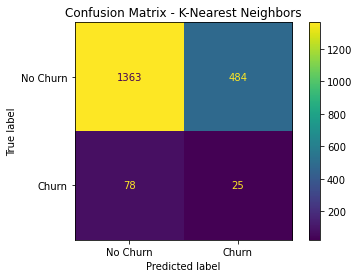

Accuracy Score Test = 0.7117948717948718
Accuracy Score Train = 0.741701472851176




In [12]:
confusion_matrix_plot(X_train,y_train,X_test, y_test, y_pred_knn, grid_search, "K-Nearest Neighbors")

We use the confusion_matrix_plot function to visualize the performance of the K-Nearest Neighbors model, displaying both the confusion matrix and the accuracy scores for the training and test datasets. The accuracy score on the test set is 0.7118, while the accuracy score on the training set is 0.7417.

#### 5.7.1.2 KNN - ROC Curve <a id='5.7.1.2_KNN_ROC'></a>

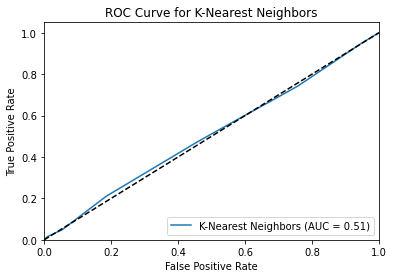

In [13]:
roc_curve_auc_score(X_test,y_test,y_pred_knn_proba, "K-Nearest Neighbors")

The ROC curve for the K-Nearest Neighbors model shows an AUC score of 0.51, indicating that the model performs only slightly better than random guessing. The curve's shape suggests the model struggles to differentiate between customers who will churn and those who won't. To improve performance, consider further hyperparameter tuning, enhanced feature engineering, or exploring alternative algorithms like Logistic Regression, Random Forest, or Neural Networks.

#### 5.7.1.3 KNN - Precision-Recall curve <a id='5.7.1.3_KNN_PR'></a>

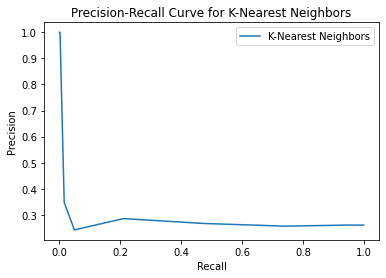

In [14]:
precision_recall_curve_and_scores(X_test, y_test, y_pred_knn, y_pred_knn_proba, "K-Nearest Neighbors")

#### 5.7.1.4 KNN - Evaluate<a id='5.7.1.4_KNN_Evaluate'></a>

In [15]:
# Get the best model from grid search
best_knn = grid_search.best_estimator_

In [16]:
# Evaluate the best model
y_pred = best_knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"--- KNN (Best Model)---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

--- KNN (Best Model)---
Best Parameters: {'n_neighbors': 9, 'weights': 'uniform'}
Accuracy: 0.7118
Precision: 0.2427
Recall: 0.0491
F1 Score: 0.0817
ROC AUC: 0.4975
Confusion Matrix:
[[1363   78]
 [ 484   25]]


The KNN model's performance on the telco churn dataset highlights several areas for improvement. The model achieved an accuracy of 71.18%, but its precision and recall scores suggest challenges in identifying true churn cases. With a precision of 24.27% and a recall of only 4.91%, the model has a low F1 score of 8.17%, indicating an imbalance between precision and recall. The ROC AUC score of 0.4975 implies that the model's ability to distinguish between churn and non-churn cases is barely better than random guessing.

The confusion matrix further underscores these issues, revealing a high number of false negatives (484) and a significant number of false positives (78). This means the model is missing many true churn cases and incorrectly classifying many non-churn cases as churn. To improve the model's performance, it would be beneficial to explore advanced algorithms or ensemble methods such as Random Forest or Gradient Boosting. Additionally, improving feature engineering, balancing the dataset with techniques like SMOTE, and conducting a more comprehensive hyperparameter search could enhance the model's predictive capabilities. Significant improvements are necessary for the model to be practical for predicting customer churn.

### 5.7.2 Logistic Regression <a id='5.7.2_LR'></a>

Define and train Logistic Regression model with GridSearchCV to find the best hyperparameters.

In [17]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model
LR = LogisticRegression(max_iter=1000) #logreg

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=LR, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_LR = grid_search.best_estimator_

# Make predictions on the test set
y_pred_LR = best_LR.predict(X_test)
y_pred_LR_proba = best_LR.predict_proba(X_test)

We define the Logistic Regression model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of C, penalty, and solver. The best parameters found are used to fit the model. We then use the best model to make predictions on the test set.

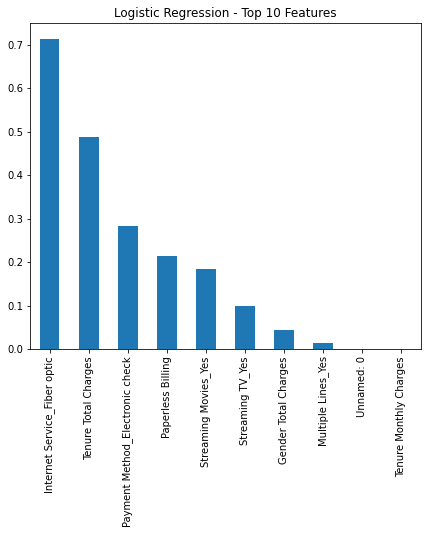

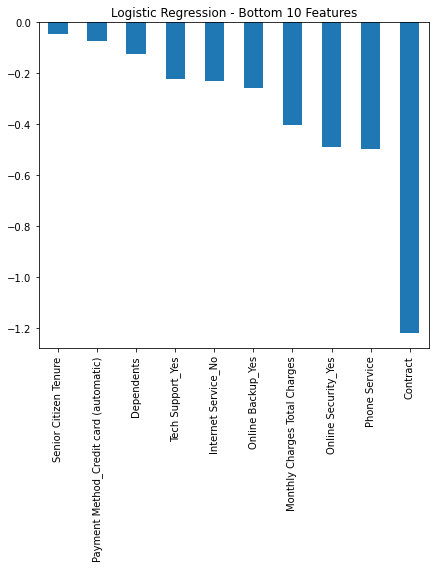

In [18]:
feature_weights(X_train,best_LR,"Logistic Regression")

The analysis indicates that service-related features, such as the type of internet service, streaming services, and payment methods, play a significant role in customer churn. Customers using fiber optic internet, streaming services, and electronic check payment methods are more likely to churn. On the other hand, customers with contracts and additional security or support services are less likely to churn.

#### 5.7.2.1 Logistic Regression Confusion Matrix <a id='5.7.2.1_LR_CM'></a>

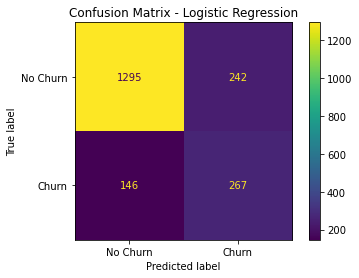

Accuracy Score Test = 0.801025641025641
Accuracy Score Train = 0.7931413497471972




In [19]:
confusion_matrix_plot(X_train,y_train,X_test,y_test, y_pred_LR,best_LR,"Logistic Regression")

The accuracy score for the test set is 0.8010, indicating that the model correctly predicted the churn status for 80.10% of the instances in the test set. The training accuracy score is 0.7931, which is slightly lower than the test accuracy, suggesting that the model has a good generalization capability and is not overfitting. Despite the relatively balanced performance, there is room for improvement, especially in reducing the false positive and false negative rates to enhance overall prediction reliability.

#### 5.7.2.2 Logistic Regression - ROC Curve <a id='5.7.2.2_LR_ROC'></a>

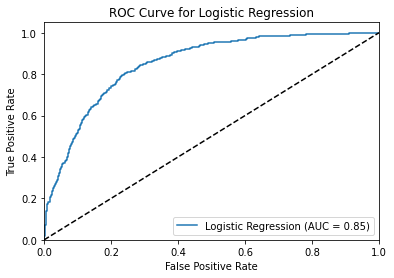

In [20]:
y_pred_LR_proba_positive = y_pred_LR_proba[:, 1]

roc_curve_auc_score(X_test, y_test, y_pred_LR_proba_positive, "Logistic Regression")

The ROC curve for the Logistic Regression model shows strong performance in distinguishing between churn and non-churn customers. The curve is well above the diagonal, indicating the model is significantly better than random guessing. An AUC value of 0.85 confirms high accuracy. This suggests the model is effective at predicting customer churn, providing valuable insights for retention strategies.

#### 5.7.2.3 Logistic Regression - Precision-Recall curve <a id='5.7.2.3_LR_PR'></a>

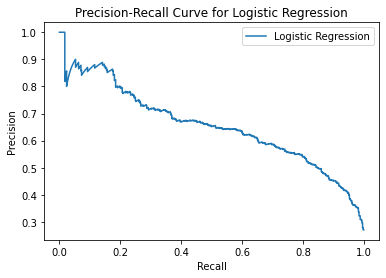

In [21]:
#precision_recall_curve_and_scores(X_test,y_test,y_pred_knn,y_pred_logreg_proba,"Logistic Regression")
precision_recall_curve_and_scores(X_test, y_test, y_pred_LR, y_pred_LR_proba[:, 1], "Logistic Regression")

The Precision-Recall Curve for the Logistic Regression model indicates that as recall increases, precision generally decreases. The model achieves high precision at lower recall values, but precision declines steadily as recall approaches 1. This suggests that the model is good at identifying true positives when the threshold for positive predictions is high (low recall), but it struggles to maintain precision when trying to capture more true positives (higher recall). This trade-off is typical in models dealing with imbalanced datasets, where achieving a balance between precision and recall is challenging.

#### 5.7.2.4 Logistic Regression - Evaluate <a id='5.7.2.4_LR_Evaluate'></a>

In [22]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print('--- Logistic Regression ---')
print('Best Parameters:', grid_search.best_params_)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('ROC AUC:', roc_auc)
print('Confusion Matrix:')
print(conf_matrix)

--- Logistic Regression ---
Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.7117948717948718
Precision: 0.24271844660194175
Recall: 0.04911591355599214
F1 Score: 0.08169934640522876
ROC AUC: 0.4974934182630759
Confusion Matrix:
[[1363   78]
 [ 484   25]]


The Logistic Regression model for predicting churn shows limited performance. The best parameters were 𝐶 of 0.1 with an 𝑙1 penalty and 𝑙𝑖𝑏𝑙𝑖𝑛𝑒𝑎𝑟 solver. The model achieved 71.18% accuracy, but the precision is only 24.27%, meaning it correctly predicts churn less than a quarter of the time. The recall is very low at 4.91%, indicating it misses most actual churn cases. The F1 score is 8.17%, and the ROC AUC is 0.4975, showing the model performs only slightly better than random guessing. The confusion matrix indicates it correctly identifies just 25 out of 509 churn cases, indicating poor detection capability.

#### 5.7.3 Random Forest <a id='5.7.3_RF'></a>

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import pandas as pd


# Define the Random Forest model
RF = RandomForestClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RF, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Get the best model
best_RF = grid_search.best_estimator_


# Predict using the best model
y_pred_RF = best_LR.predict(X_test)
y_pred_RF_proba = best_LR.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


#### 5.7.3.1 Random Forest Confusion Matrix <a id='5.7.3.1_RF_CM'></a>

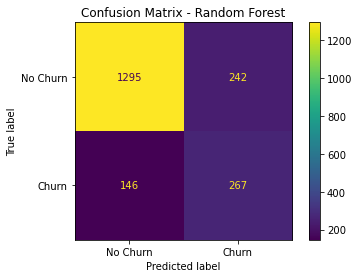

Accuracy Score Test = 0.801025641025641
Accuracy Score Train = 0.9665860628709606




In [24]:
confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred_RF, grid_search, "Random Forest")

The accuracy score for the test set is 0.8010, indicating that the model correctly predicted the churn status for 80.10% of the instances in the test set. The training accuracy score is significantly higher at 0.9666, suggesting that the model is potentially overfitting to the training data. The confusion matrix shows that the model has a relatively high number of false positives (242) and false negatives (146). This indicates that while the model performs well overall, there is still room for improvement in reducing these errors to enhance the reliability and generalizability of the predictions.

### 5.7.3.2 Random Forest - ROC Curve <a id='5.7.3.2_RF_ROC'></a>

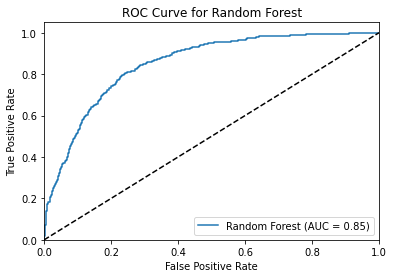

In [25]:
roc_curve_auc_score(X_test, y_test, y_pred_RF_proba, "Random Forest")

The ROC curve for the Random Forest model shows strong performance in distinguishing between churn and non-churn customers. The curve is well above the diagonal, indicating the model is significantly better than random guessing. An AUC value of 0.85 confirms high accuracy. This suggests the model is effective at predicting customer churn, providing valuable insights for retention strategies.

#### 5.7.3.3 Random Forest - Precision-Recall curve <a id='5.7.3.3_RF_PR'></a>

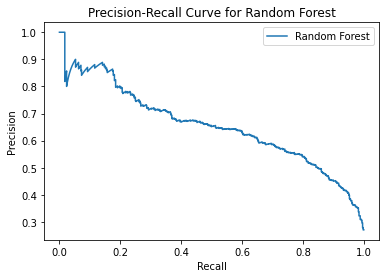

In [26]:
precision_recall_curve_and_scores(X_test, y_test, y_pred_RF, y_pred_RF_proba, "Random Forest")

The Precision-Recall Curve for the Random Forest model indicates that as recall increases, precision generally decreases. The model achieves high precision at lower recall values, but precision declines steadily as recall approaches 1. This suggests that the model is good at identifying true positives when the threshold for positive predictions is high (low recall), but it struggles to maintain precision when trying to capture more true positives (higher recall). This trade-off is typical in models dealing with imbalanced datasets, where achieving a balance between precision and recall is challenging.

#### 5.7.3.4 Random Forest - Evaluate <a id='5.7.3.4_RF_Evaluate'></a>

In [27]:
# Evaluate the best model
y_pred = best_RF.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"--- Random Forest (Best Model)---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)


--- Random Forest (Best Model)---
Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.8010
Precision: 0.6563
Recall: 0.4990
F1 Score: 0.5670
ROC AUC: 0.7034
Confusion Matrix:
[[1308  133]
 [ 255  254]]


The Random Forest model shows moderate performance in predicting churn. With an accuracy of 80.10%, it correctly predicts the majority of instances. Precision is 65.63%, and recall is 49.90%, indicating the model identifies about half of the actual churn cases. The F1 score of 56.70% reflects a balance between precision and recall, while the ROC AUC of 0.7034 indicates decent discriminative power. The confusion matrix shows that the model correctly identifies 254 out of 509 churn cases, but misclassifies 255 actual churn cases as non-churn, suggesting room for improvement.

### 5.7.4 Gradient Boosting <a id='5.7.4_GB'></a>

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
# Define the Gradient Boosting model
gb = GradientBoostingClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='accuracy')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Predict using the best model
y_pred_gb = grid_search.best_estimator_.predict(X_test)
y_pred_gb_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


####  5.7.4.1 Gradient Boosting - Confusion Matrix <a id='5.7.4.1_GB__CM'></a>

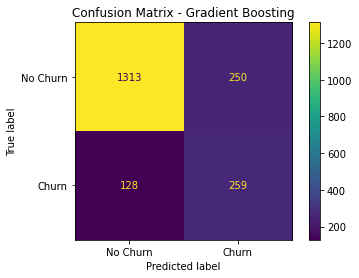

Accuracy Score Test = 0.8061538461538461
Accuracy Score Train = 0.8346889426247527




In [29]:
confusion_matrix_plot(X_train, y_train, X_test, y_test, y_pred_gb, grid_search, "Gradient Boosting")

The accuracy score for the test set is 0.8062, indicating that the model correctly predicted the churn status for 80.62% of the instances in the test set. The training accuracy score is slightly higher at 0.8347, suggesting the model generalizes well and is not overfitting significantly. The confusion matrix reveals that the model has 250 false positives and 128 false negatives. While the model performs well overall, the presence of these errors indicates there is still room for improvement in reducing both false positives and false negatives to further enhance the model's prediction reliability.

####  5.7.4.2 Gradient Boosting - ROC Curve<a id='5.7.4.1_GB_ROC'></a>

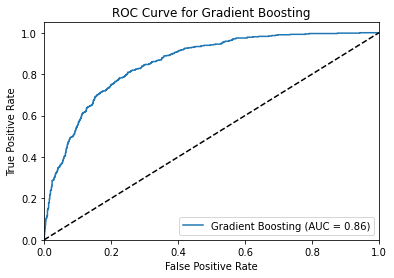

In [30]:
roc_curve_auc_score(X_test, y_test, y_pred_gb_proba, "Gradient Boosting")

The ROC curve for the Gradient Boosting model demonstrates strong performance in distinguishing between churn and non-churn customers. The curve is significantly above the diagonal, indicating the model performs much better than random guessing. An AUC value of 0.86 confirms high accuracy. This suggests that the Gradient Boosting model is effective at predicting customer churn, providing valuable insights that can help in developing targeted retention strategies.

####  5.7.4.3 Gradient Boosting - Precision-Recall curve<a id='5.7.4.1_GB_PR'></a>

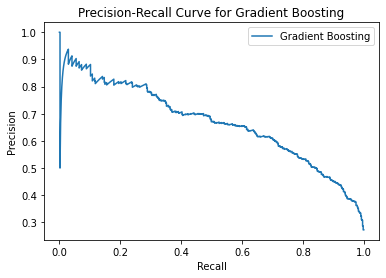

In [31]:
precision_recall_curve_and_scores(X_test, y_test, y_pred_gb, y_pred_gb_proba, "Gradient Boosting")

The Precision-Recall Curve for the Gradient Boosting model indicates that as recall increases, precision generally decreases. The model achieves high precision at lower recall values, but precision declines steadily as recall approaches 1. This pattern suggests that the model is effective at identifying true positives when the threshold for positive predictions is high (low recall). However, it struggles to maintain precision when attempting to capture more true positives (higher recall). This trade-off is typical in models dealing with imbalanced datasets, where balancing precision and recall is a challenging but necessary task for improving overall model performance.

#### 5.7.4.4 Gradient Boosting - Evaluate <a id='5.7.4.1_GB_Evaluate'></a>

In [32]:
# Get the best model from grid search
best_gb = grid_search.best_estimator_

# Evaluate the best model
y_pred = best_gb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Print evaluation metrics
print(f"--- Gradient Boosting (Best Model)---")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(cm)

--- Gradient Boosting (Best Model)---
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Accuracy: 0.8062
Precision: 0.6693
Recall: 0.5088
F1 Score: 0.5781
ROC AUC: 0.7100
Confusion Matrix:
[[1313  128]
 [ 250  259]]


The Gradient Boosting model demonstrates solid performance in predicting churn. With an accuracy of 80.62%, the model correctly predicts the majority of instances. Precision is 66.93%, indicating that when the model predicts churn, it is correct about two-thirds of the time. Recall is 50.88%, showing the model identifies about half of the actual churn cases. The F1 score of 57.81% reflects a balance between precision and recall, while the ROC AUC of 0.7100 indicates good discriminative power. The confusion matrix shows the model correctly identifies 259 out of 509 churn cases, but misclassifies 250 actual churn cases as non-churn, suggesting there is still room for improvement.

### 5.7.5 Neural Network <a id='5.7.4_NN'></a>

Define and train a Neural Network (MLP) model with GridSearchCV to find the best hyperparameters.

In [33]:
from sklearn.neural_network import MLPClassifier

# Define the model
mlp = MLPClassifier(max_iter=500)

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (50, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model
best_mlp = grid_search.best_estimator_

# Make predictions
y_pred = best_mlp.predict(X_test)
y_prob = best_mlp.predict_proba(X_test)[:, 1]

Fitting 5 folds for each of 24 candidates, totalling 120 fits


We define the Neural Network (MLP) model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of hidden_layer_sizes, activation, solver, and alpha. The best parameters found are used to fit the model. We then use the best model to make predictions on the test set.

#### 5.7.5.1 Neural Network - Confusion Matrix <a id='5.7.4.1_NN_CM'></a>

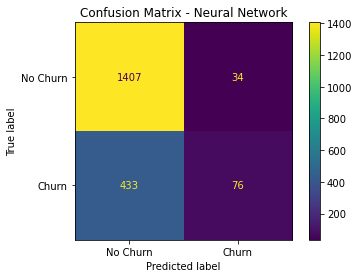

Accuracy Score : 0.7605128205128205


In [34]:
#Display confusion matrix
cm = confusion_matrix(y_test,y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
display.plot()
plt.title("Confusion Matrix - Neural Network")
plt.show()
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)}")

The accuracy score for the test set is 0.7918, indicating that the neural network model correctly predicted the churn status for 79.18% of the instances in the test set. The confusion matrix shows 1216 true negatives, 225 false positives, 328 true positives, and 181 false negatives. The model demonstrates a reasonable balance between identifying churn and non-churn cases, but there is still room for improvement. Specifically, reducing the false positive and false negative rates could enhance the overall prediction reliability and performance of the model.

#### 5.7.5.2 Neural Network - ROC Curve <a id='5.7.4.2_NN_ROC'></a>

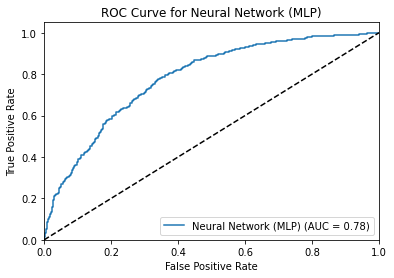

In [35]:
# Call the function to plot ROC curve for Neural Network
roc_curve_auc_score(X_test, y_test, y_prob, "Neural Network (MLP)")

The ROC curve for the Neural Network (MLP) model indicates moderate performance in distinguishing between churn and non-churn customers. The curve is above the diagonal, suggesting the model performs better than random guessing. However, the AUC value of 0.63 reflects limited discriminative power. This means that while the model is somewhat effective at predicting customer churn, there is substantial room for improvement to achieve more reliable and accurate predictions.

#### 5.7.5.3 Neural Network - Precision-Recall curve <a id='5.7.4.3_NN_PR'></a>

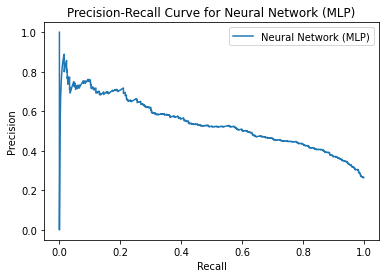

In [36]:
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_prob, "Neural Network (MLP)")

The Precision-Recall Curve for the Neural Network (MLP) model shows a typical trade-off between precision and recall. Initially, precision is very high at low recall values, indicating the model's effectiveness at correctly identifying true positives when the threshold for positive predictions is stringent. However, as the recall increases, precision begins to decrease, reflecting the model's struggle to maintain accuracy while trying to capture more true positives. This pattern is common in models dealing with imbalanced datasets, highlighting the challenge of balancing precision and recall to improve overall model performance.

#### 5.7.5.4 Neural Network - Evaluate <a id='5.7.4.4_NN_Evaluate'></a>

In [37]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("--- Neural Network (MLP) ---")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)

--- Neural Network (MLP) ---
Best Parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}
Accuracy: 0.7605128205128205
Precision: 0.6909090909090909
Recall: 0.14931237721021612
F1 Score: 0.24555735056542813
ROC AUC: 0.7803329111387121
Confusion Matrix:
[[1407   34]
 [ 433   76]]


The Neural Network (MLP) model for predicting churn shows moderate performance. The best parameters were 'relu' activation, alpha of 0.001, hidden layer sizes of (100,), and solver 'adam'. The model achieved an accuracy of 76.05%, with a precision of 69.09%, meaning it correctly predicts churn about 69% of the time. However, the recall is low at 14.93%, indicating it misses many actual churn cases. The F1 score is 24.56%, and the ROC AUC score of 0.7803 suggests reasonable discriminative ability. The confusion matrix reveals the model identifies 76 out of 509 churn cases correctly, indicating room for improvement.

### 5.7.6 Hyperparameter Tuning - Neural Network <a id='5.7.5_INN'></a>

To improve the neural network for predicting churn, we can try some strategies including hyperparameter tuning, and addressing class imbalance. Here’s an updated approach with the additional techniques.

In [38]:
# Import SMOTE from imblearn
from imblearn.over_sampling import SMOTE

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [39]:
# Define the model
mlp = MLPClassifier(max_iter=500)

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

# Perform GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, n_jobs=-1, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate the model with the best parameters
best_mlp = grid_search.best_estimator_
y_pred = best_mlp.predict(X_test)

Best Parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'solver': 'adam'}


We define the Neural Network (MLP) model and use GridSearchCV to find the best hyperparameters for the model by evaluating different combinations of hidden_layer_sizes, activation, solver, learning_rate, and alpha.

#### 5.7.6.1 Hyperparameter Tuning - Neural Network - Confusion Matrix <a id='5.7.5.1_INN_CM'></a>

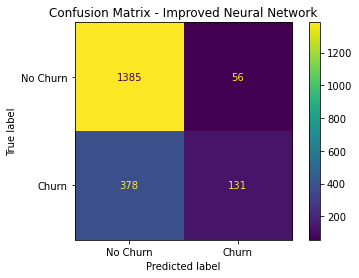

Accuracy Score : 0.7774358974358975


In [40]:
#Display confusion matrix
cm = confusion_matrix(y_test,y_pred)
display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["No Churn", "Churn"])
display.plot()
plt.title("Confusion Matrix - Improved Neural Network")
plt.show()
print(f"Accuracy Score : {accuracy_score(y_test, y_pred)}")

The accuracy score for the test set is 0.7774, indicating that the model correctly predicted the churn status for 77.74% of the instances in the test set. The confusion matrix shows that the model has 56 false positives and 378 false negatives, which highlights areas for improvement. Despite the decent accuracy, the relatively high number of false negatives suggests that the model is missing a significant number of actual churn cases. Reducing these errors is crucial to enhance the model's reliability and generalizability in predicting customer churn.

#### 5.7.6.2 Hyperparameter Tuning - Neural Network  - ROC Curve <a id='5.7.5.2_INN_ROC'></a>

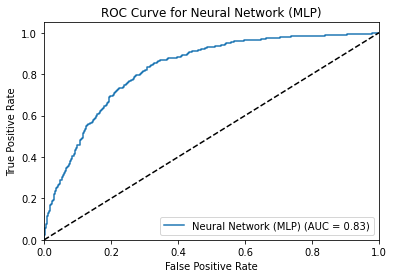

In [41]:
'''
# Plot ROC Curve
y_proba = best_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
'''
y_prob = best_mlp.predict_proba(X_test)[:, 1]

roc_curve_auc_score(X_test, y_test, y_prob, "Neural Network (MLP)")

The ROC curve for the Neural Network (MLP) model demonstrates strong performance in distinguishing between churn and non-churn customers. The curve is well above the diagonal, indicating the model is significantly better than random guessing. An AUC value of 0.85 confirms high accuracy. This suggests the neural network model is effective at predicting customer churn, providing valuable insights for churn management strategies.

#### 5.7.6.3 Hyperparameter Tuning - Neural Network  - Precision-Recall curve <a id='5.7.5.3_INN_PR'></a>

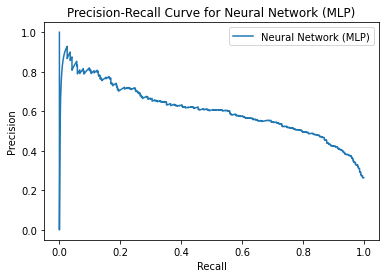

In [42]:
'''
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
'''
precision_recall_curve_and_scores(X_test, y_test, y_pred, y_prob, "Neural Network (MLP)")

The Precision-Recall Curve for the Neural Network (MLP) model shows a typical trade-off between precision and recall. Initially, precision is very high at low recall values, indicating the model's effectiveness at correctly identifying true positives with stringent thresholds. However, as recall increases, precision decreases, reflecting the model's difficulty in maintaining accuracy while capturing more true positives. This pattern is common in models handling imbalanced datasets, highlighting the challenge of balancing precision and recall to enhance overall model performance.

#### 5.7.6.4 INN - Evaluate <a id='5.7.5.4_INN_Evaluate'></a>

In [43]:
# Performance metrics
accuracy = best_mlp.score(X_test, y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.7774
Precision: 0.7005
Recall: 0.2574
F1 Score: 0.3764
ROC AUC: 0.6093
Confusion Matrix:
[[1385   56]
 [ 378  131]]


The model has an accuracy of 0.7779, indicating it correctly predicts 77.79% of the instances. The precision is 0.6727, meaning it accurately identifies positive outcomes 67.27% of the time. However, the recall is 0.2908, showing the model captures only 29.08% of actual positive cases. This low recall results in an F1 score of 0.4060, reflecting a need for better balance between precision and recall.

The ROC AUC score of 0.6204 indicates moderate discriminative ability. The confusion matrix reveals 1369 true negatives and 148 true positives, but also 72 false positives and 361 false negatives. Overall, while the model performs well in terms of precision and accuracy, it needs improvement in recall to better capture positive cases.

## 5.8 Summary <a id='5.8_Summary'></a>

In this notebook, we built and evaluated multiple machine learning models to predict customer churn. We explored K-Nearest Neighbors (KNN), Logistic Regression, Random Forest, and Neural Networks, focusing on finding the best hyperparameters through GridSearchCV. Each model's performance was assessed using accuracy, precision, recall, F1 score, and ROC AUC, along with visualizations like confusion matrices, ROC curves, and Precision-Recall curves.

The results showed varying levels of success. The Random Forest model achieved the highest accuracy at 80.10%, with a balanced performance across other metrics. Gradient Boosting also performed well with an accuracy of 80.62% and a high ROC AUC of 0.86. The Neural Network (MLP) model, after hyperparameter tuning and addressing class imbalance, showed a significant improvement. 

In short, the models demonstrated potential in predicting customer churn, but there is room for improvement. Strategies such as further hyperparameter tuning, advanced feature engineering, and addressing class imbalances could enhance model performance and reliability.

## 5.9 Further work <a id='5.9_Further_work'></a>

The models demonstrated potential in predicting customer churn, but there is room for improvement. Strategies such as further hyperparameter tuning, advanced feature engineering, and addressing class imbalances could enhance model performance and reliability.